##  加载库及配置

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import scale

In [2]:
mpl.rcParams['figure.figsize'] = [11.0, 6.0]
sns.set_palette('pastel')

## 加载数据集

In [3]:
train_data = pd.read_csv('data/train.csv')

In [4]:
train_data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
732,733,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.0000,NaN,S
824,825,0,3,"Panula, Master. Urho Abraham",male,2.0,4,1,3101295,39.6875,NaN,S
462,463,0,1,"Gee, Mr. Arthur H",male,47.0,0,0,111320,38.5000,E63,S
384,385,0,3,"Plotcharsky, Mr. Vasil",male,NaN,0,0,349227,7.8958,NaN,S
702,703,0,3,"Barbara, Miss. Saiide",female,18.0,0,1,2691,14.4542,NaN,C


## 数据可视化

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doin

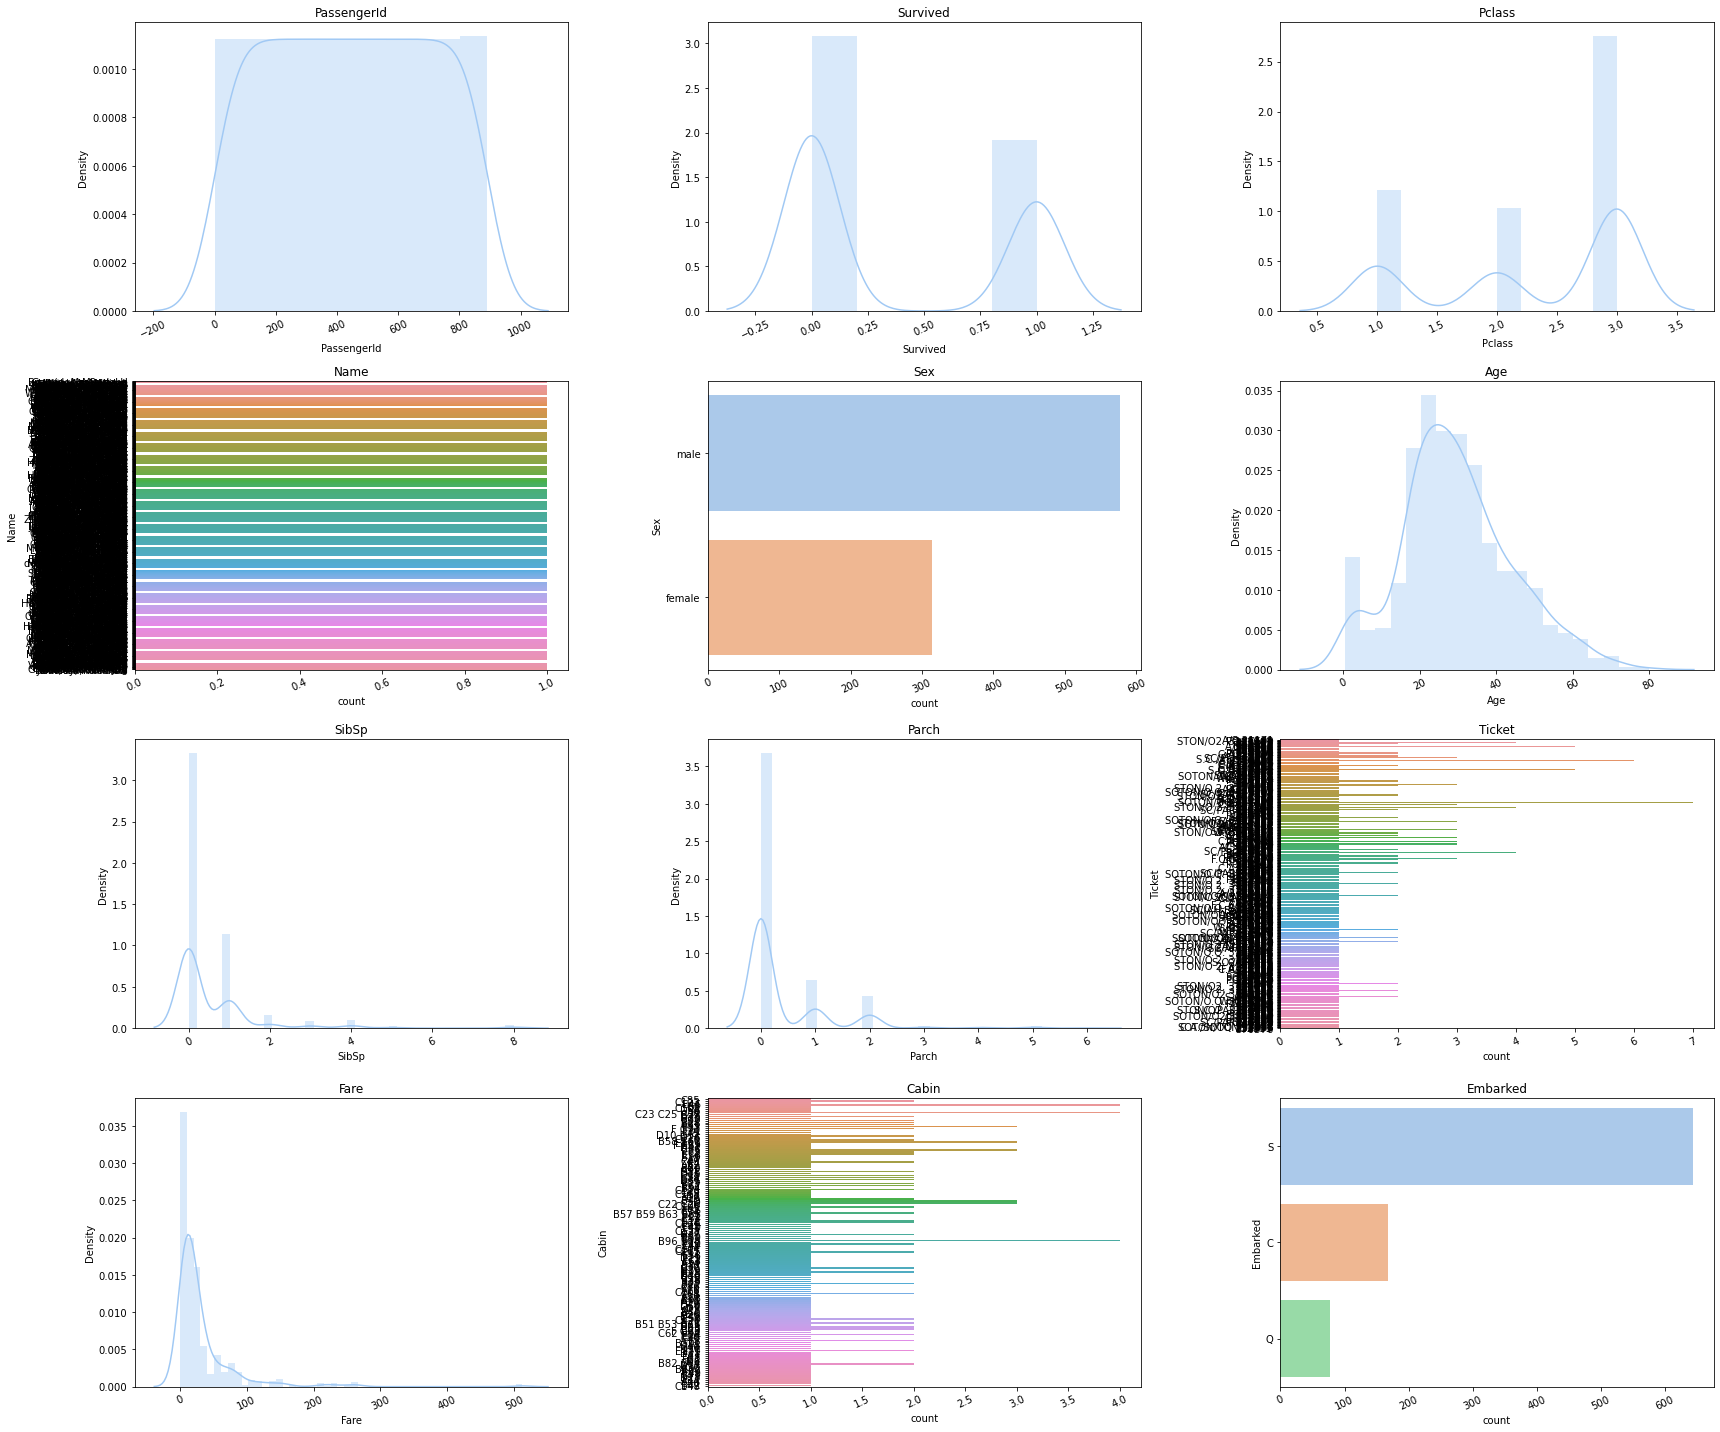

In [5]:
import math
def plot_distribution(dataset, cols, width, height, hspace, wspace):
    fig = plt.figure(figsize = (width, height))
    fig.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=wspace,hspace=hspace)
    rows = math.ceil(dataset.shape[1] / cols)
    for i,column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels = substrings)
            plt.xticks(rotation = 25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation = 25)
    plt.tight_layout()
plot_distribution(train_data, cols=3, width=24, height=20, hspace=0.2, wspace=0.5)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


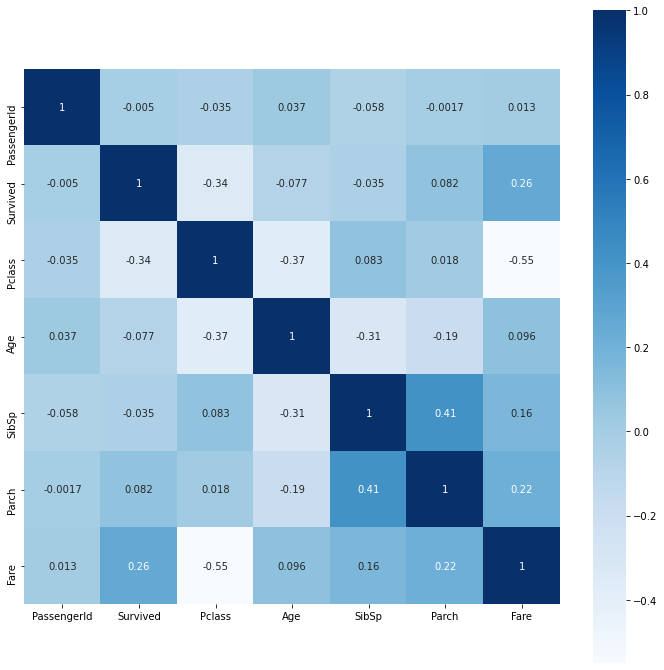

In [6]:
# 查找关联度
corr_matrix = train_data.corr()
print(corr_matrix["Survived"].sort_values(ascending=False))
# 展示各特征之间的相关性
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True, vmax=1, square=True, cmap='Blues')
plt.show()

## 数据预处理

<AxesSubplot:>

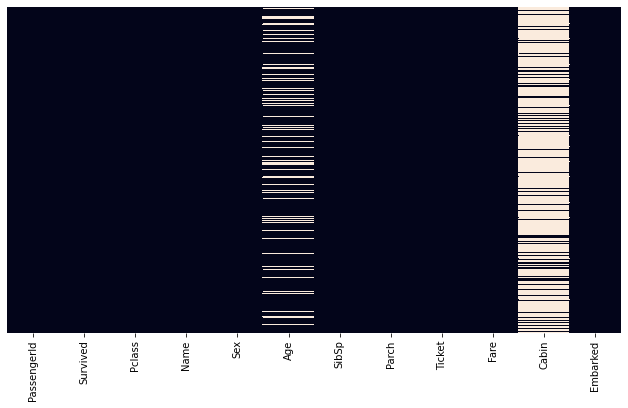

In [7]:
sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False)

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

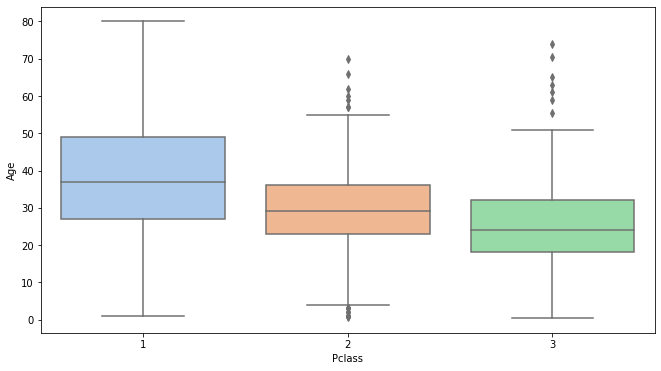

In [8]:
sns.boxplot(x='Pclass',y='Age',data=train_data)

### 缺失值处理

In [9]:
# Cabin属性在测试集和训练集中都缺失过多，可以将这一特征处理成有和无两种属性
train_data.loc[ train_data.Cabin.notnull(), 'Cabin' ] = 'Yes'
train_data.loc[ train_data.Cabin.isnull(), 'Cabin' ] = 'No'

 
# 训练集中的Embarked和测试集中的Fare属性缺失数量较少，采用相应的属性中最多的项或平均值来补全
train_data['Embarked'].fillna('S', inplace=True)
 
# 用年龄的平均值补全训练集和测试集中的年龄属性
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True)
 
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### one-hot 编码

In [10]:
train_dummies_Pclass = pd.get_dummies(train_data['Pclass'], prefix='Pclass')
train_dummies_Sex = pd.get_dummies(train_data['Sex'], prefix='Sex')
train_dummies_SibSp = pd.get_dummies(train_data['SibSp'], prefix='SibSp')
train_dummies_Parch = pd.get_dummies(train_data['Parch'], prefix='Parch')
train_dummies_Cabin = pd.get_dummies(train_data['Cabin'], prefix='Cabin')
train_dummies_Embarked = pd.get_dummies(train_data['Embarked'], prefix='Embarked')

In [11]:
# 将one-hot编码表示的属性拼接在原来的数据集上，保存到train_df中
train_df = pd.concat([train_data, train_dummies_Pclass, train_dummies_Sex, train_dummies_SibSp, train_dummies_Parch, train_dummies_Cabin, train_dummies_Embarked], axis=1)
train_df.drop(['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked'], axis=1, inplace=True)

In [12]:
train_df.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.2500,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,71.2833,1,0,0,1,...,0,0,0,0,0,0,1,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7.9250,0,0,1,1,...,0,0,0,0,0,1,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53.1000,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,373450,8.0500,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


### 标准化

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df['Age'].values.reshape(-1,1))
train_df['Age_scaled'] = scaler.transform(train_df['Age'].values.reshape(-1,1))
 
scaler.fit(train_df['Fare'].values.reshape(-1,1))
train_df['Fare_scaled'] = scaler.transform(train_df['Fare'].values.reshape(-1,1))
 
train_df.drop(['Age', 'Fare'], axis=1, inplace=True)
train_df.drop(['Name', 'Ticket','PassengerId'], axis=1, inplace=True)

train_df.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_4,Parch_5,Parch_6,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Age_scaled,Fare_scaled
0,0,0,0,1,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,-0.592481,-0.502445
1,1,1,0,0,1,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0.638789,0.786845
2,1,0,0,1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,1,-0.284663,-0.488854
3,1,1,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0.407926,0.420730
4,0,0,0,1,0,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0.407926,-0.486337


### 一些特征工程

## SVM过程

In [18]:
# 划分数据集
X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    train_df.drop('Survived', axis=1), train_data['Survived'], test_size=.25
)

In [19]:
X_train

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,...,Parch_4,Parch_5,Parch_6,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Age_scaled,Fare_scaled
174,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,1,0,0,2.023967,-0.030371
797,0,0,1,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0.100109,-0.473586
691,0,0,1,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,-1.977659,-0.378281
818,0,0,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,1.023561,-0.518553
670,0,1,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0.792698,0.136831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,-0.361618,2.402990
637,0,1,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0.100109,-0.119886
809,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0.254017,0.420730
315,0,0,1,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,-0.284663,-0.490280


In [20]:
svmmodel = SVC( kernel='rbf')
svmmodel.fit(X_train, y_train)

predictions = svmmodel.predict(X_test)

print(classification_report(predictions, y_test))


              precision    recall  f1-score   support

           0       0.91      0.82      0.87       153
           1       0.68      0.83      0.75        70

    accuracy                           0.83       223
   macro avg       0.80      0.83      0.81       223
weighted avg       0.84      0.83      0.83       223



In [21]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y, y_pred, cmap=plt.cm.Blues, title='混淆矩阵'):
    """
    绘制混淆矩阵
    :param y: 真实值
    :param y_pred: 预测值
    :param cmap: 热力图的颜色
    :param title: 图像标题
    :return:
    """
    cm = confusion_matrix(y, y_pred)
    classes = list(set(y))
    classes.sort()
    plt.imshow(cm, cmap)
    indices = range(len(cm))
    plt.xticks(indices, classes)
    plt.yticks(indices, classes)
    # 热度表
    plt.colorbar()
    # 坐标轴含义
    plt.xlabel('guess')
    plt.ylabel('fact')
    plt.title(title)
    # 显示数据的值（Numbers）
    for first_index in range(len(cm)):
        for second_index in range(len(cm[first_index])):
            plt.text(first_index, second_index, cm[first_index][second_index])

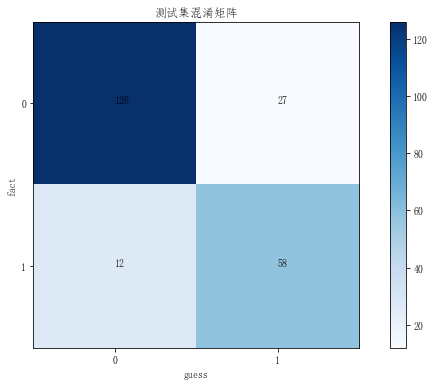

In [22]:
# 输出混淆矩阵
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
plot_confusion_matrix(y_test,
                          predictions,
                          title='测试集混淆矩阵')
plt.show()

## 优化

In [25]:
# 1)参数优化
# 用网格搜索自动化选取最优参数
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X_train,y_train)
print(gsearch.best_params_, gsearch.best_score_)


C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeW

{'classify__max_depth': 6, 'classify__n_estimators': 44} 0.8732954525149648


C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [18] are constant.
  UserWarning)
C:\Users\29459\anaconda3\envs\python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
